# COVID-19 Case Study
## DATASCI 347
Xinmo Chen

Aadit Narayanan

Daniel Nickas

# 1) There are two main goals for this case study:

1. We show the dynamic evolvement of COVID cases and COVID-related death at state level.
2. We try to figure out what county-level demographic and policy interventions are associated
with mortality rate in the US. We try to construct models to find possible factors related to
county-level COVID-19 mortality rates.

# 2) Data Summary:

#### County-level infection and fatality data  

- This dataset gives daily cumulative numbers on infection and fatality for each county.

#### NYC data

#### County-level socioeconomic data

- The following are the four relevant datasets from this site:
    - Income - Poverty level and household income.
    - Jobs - Employment type, rate, and change.
    - People - Population size, density, education level, race, age, household size, and migration
rates.
    - County Classifications - Type of county (rural or urban on a rural-urban continuum
scale).

#### Intervention Policy Data 

- This dataset is a manually compiled list of the dates that interventions/lockdown policies were implemented and lifted at the county level.

# 3) EDA:

### In this case study, we use the following three cleaned data:

##### covid_county.csv: County-level socioeconomic information that combines the above-mentioned
    - 4 datasets Income, Jobs, People, and County Classifications

##### covid_rates.csv: Daily cumulative numbers on infection and fatality for each county

##### covid_intervention.csv: County-level lockdown intervention.

*Among all data, the unique identifier of county is FIPS.*

## 3.1) Understanding the Data

#### Covid County dataset (covid_county.csv):

Covid County concerns socioeconomic data ranging from the 2000s to the 2020s. A FIPS code (unique county identifier) acts as the join key to other datasets. Data related to population characterstics such as income, education, employment, race, location, location characteristics (metro vs. non metro areas) are crucial to finding what variables may (or may not) impact the effect of covid intervention policies. Socioeconomic variables from mixed sources/years have suppressed values for some counties, yielding scattered nulls across income, poverty, education, and related fields...this may be attributed to poor data recording or insufficient research. Structure of the data is shown below.


#### Covid Rates dataset (covid_rates.csv):

Covid Rates is a panel data that includes date (observation date), county and state (names), FIPS (unique county code), and cases and deaths (cumulative counts). A FIPS code (unique identifier) as the join key to other county datasets, parse date as a date type, and keep FIPS as a string to preserve leading zeros. Counts are cumulative from January 2020 to February 2021, so differentiating by date within county yields daily new cases and deaths. Structure of data is shown below. Daily cumulative series have gaps/backfills that produce NaNs in some dates/counts and occasional missing FIPS/population fields affecting per-100k calculations.

#### Intervention (covid_intervention.csv):

The Covid Intervention dataset is a county-level timeline of non-pharmaceutical COVID-19 policies. Each row records a policy event for a county (keyed by FIPS code) including the policy type (e.g., stay-at-home, school/business closures, gathering limits, mask mandates), the date it was implemented, and when it was lifted (noted as missing if still in effect at the time this data was finalized in this form). Counties can have multiple rows for different policy types or changes over time. Use FIPS to join to covid_rates and align by date ranges to construct policy exposure indicators and analyze associations with cases/deaths. Event records often lack lift (end) dates and some county-policy entries, so nulls indicate policies still in effect or unreported. Structure of data is shown below. 

In [27]:
# import packages
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [28]:
# County-level Socioeconomic data 
covid_county = pd.read_csv('covid_county.csv')
print(covid_county)
print("data types:", covid_county.dtypes)
print("data summary:", covid_county.describe())
print("missing data:", covid_county.isnull().sum())


       FIPS State         County  MedHHInc  PerCapitaInc  PovertyUnder18Pct  \
0         0    US  United States   61937.0       32621.0               18.0   
1      1000    AL        Alabama   49881.0       26846.0               23.9   
2      1001    AL        Autauga   59338.0       29372.0               19.3   
3      1003    AL        Baldwin   57588.0       31203.0               13.9   
4      1005    AL        Barbour   34382.0       18461.0               43.9   
...     ...   ...            ...       ...           ...                ...   
3274  72147    PR        Vieques       NaN       11156.0                NaN   
3275  72149    PR       Villalba       NaN       10677.0                NaN   
3276  72151    PR        Yabucoa       NaN        9148.0                NaN   
3277  72153    PR          Yauco       NaN        8339.0                NaN   
3278  72153    PR          Yauco       NaN        8339.0                NaN   

      PovertyAllAgesPct  Deep_Pov_All  Deep_Pov_Chi

In [29]:
# County level infection data
covid_rates = pd.read_csv("covid_rates.csv")
print(covid_rates)
print("data types:", covid_rates.dtypes)
print("data summary:", covid_rates.describe())
print("missing data:", covid_rates.isnull().sum)


          FIPS        date   County        State  cum_cases  cum_deaths  week  \
0        10001  2020-03-18     Kent     Delaware          3           0     9   
1        10001  2020-03-19     Kent     Delaware          4           0     9   
2        10001  2020-03-20     Kent     Delaware          4           0     9   
3        10001  2020-03-21     Kent     Delaware          5           0     9   
4        10001  2020-03-22     Kent     Delaware          5           0    10   
...        ...         ...      ...          ...        ...         ...   ...   
1008979   9015  2021-02-16  Windham  Connecticut       8963         172    57   
1008980   9015  2021-02-17  Windham  Connecticut       8974         174    57   
1008981   9015  2021-02-18  Windham  Connecticut       8976         174    57   
1008982   9015  2021-02-19  Windham  Connecticut       9028         176    57   
1008983   9015  2021-02-20  Windham  Connecticut       9028         176    57   

         TotalPopEst2019  


In [30]:
# Intervention policy csv
intervention = pd.read_csv("covid_intervention.csv")
print(intervention)
print("data types:", intervention.dtypes)
print("data summary:", intervention.describe())
print("missing data:", intervention.isnull().sum())


       FIPS STATE                         AREA_NAME stay at home  \
0      1000    AL                           alabama   2020-04-05   
1      1001    AL                    autauga county   2020-04-05   
2      1003    AL                    baldwin county   2020-04-05   
3      1005    AL                    barbour county   2020-04-05   
4      1007    AL                       bibb county   2020-04-05   
...     ...   ...                               ...          ...   
3267  72145    PR  vega baja municipio, puerto rico          NaN   
3268  72147    PR    vieques municipio, puerto rico          NaN   
3269  72149    PR   villalba municipio, puerto rico          NaN   
3270  72151    PR    yabucoa municipio, puerto rico          NaN   
3271  72153    PR      yauco municipio, puerto rico          NaN   

     >50 gatherings >500 gatherings public schools restaurant dine-in  \
0        2020-03-21      2020-03-14     2020-03-17         2020-03-20   
1        2020-03-21      2020-03-14  

## 3.2 COVID case trend)

It is crucial to decide the right granularity for visualization and analysis. We will compare daily vs weekly total new cases by state and we will see it is hard to interpret daily report.

#### i) Plot new COVID cases in NY, WA and FL by state and by day. Any irregular pattern? What is the biggest problem of using single day data?

There are noticeable spikes/irregularities around holidays and "miscellaneous non-working periods." For example, Christmas and New Years periods show extreme single day spikes as compared to the rest of the data. Additionally single day data are noisy as they are purely the result of reporting data which is a lagging statistic (not completely up to date nor exact). A better alternative is to use weekly or monthly averages or totals. 

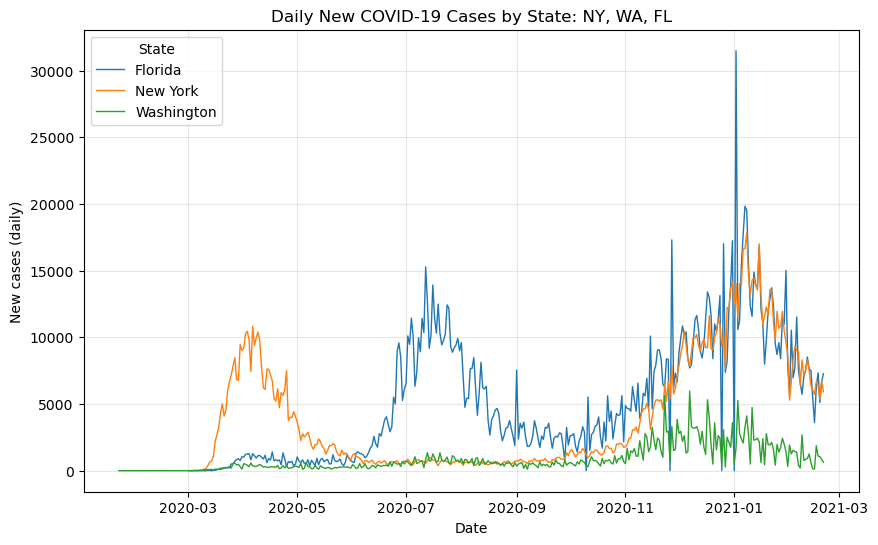

In [ ]:
# Let's use the Covid Rates dataset 

covid_rates['date'] = pd.to_datetime(covid_rates['date'], errors='coerce')

# Daily new cases by state
cases_state_daily = (
    covid_rates
    .groupby(['State', 'date'], as_index=False)['cum_cases']
    .sum()
    .sort_values(['State', 'date'])
)
cases_state_daily['new_cases'] = cases_state_daily.groupby('State')['cum_cases'].diff()

# Let's use NY, WA, FL
state_targets = ['New York', 'Washington', 'Florida']

plot_df = cases_state_daily[
    cases_state_daily['State'].isin(state_targets)
].dropna(subset=['new_cases'])


fig, ax = subplots(figsize=(10, 6))
for st, sdf in plot_df.groupby('State'):
    ax.plot(sdf['date'], sdf['new_cases'], label=st, linewidth=1.0)

ax.set_title('Daily New COVID-19 Cases by State: NY, WA, FL')
ax.set_xlabel('Date')
ax.set_ylabel('New cases (daily)')
ax.legend(title='State')
ax.grid(alpha=0.3)


#### ii) Create weekly new cases per 100k weekly case per100k. Plot the spaghetti plots of weekly case per100k by state. Use TotalPopEst2019 as population.



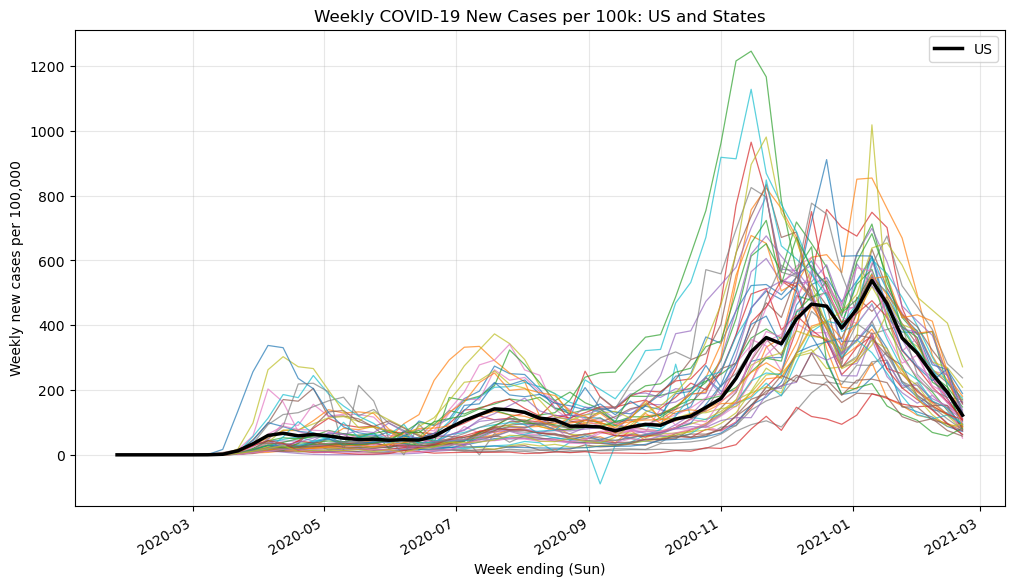

In [ ]:
# Clean types/labels
covid_rates['date'] = pd.to_datetime(covid_rates['date'], errors='coerce')
covid_rates['State'] = covid_rates['State'].astype(str).str.strip()
covid_rates['cum_cases'] = pd.to_numeric(covid_rates['cum_cases'], errors='coerce')

# 1) Daily new cases at state level from cumulative counts
cases_state_daily = (
    covid_rates
    .groupby(['State', 'date'], as_index=False)['cum_cases']
    .sum()
    .sort_values(['State', 'date'])
)
cases_state_daily['new_cases'] = (
    cases_state_daily
    .groupby('State')['cum_cases']
    .diff()
)

# 2) Weekly aggregation (Sun-ending weeks)
state_weekly = (
    cases_state_daily
    .groupby(['State', pd.Grouper(key='date', freq='W-SUN')], as_index=False)['new_cases']
    .sum()
    .rename(columns={'date': 'week_end', 'new_cases': 'weekly_new_cases'})
)

# 3) Build state populations from county-level rows in covid_rates (deduplicate counties)
county_pop = (
    covid_rates[['FIPS', 'State', 'TotalPopEst2019']]
    .dropna(subset=['FIPS', 'TotalPopEst2019'])
    .drop_duplicates(subset=['FIPS'])
    .groupby('State', as_index=False)['TotalPopEst2019']
    .sum()
)

# Merge population; compute per 100k
state_weekly = state_weekly.merge(county_pop, on='State', how='left')
state_weekly['weekly_per100k'] = (
    state_weekly['weekly_new_cases'] / state_weekly['TotalPopEst2019']
) * 1e5

# 4) US aggregate per 100k
us_weekly = (
    state_weekly
    .groupby('week_end', as_index=False)
    .agg(weekly_new_cases=('weekly_new_cases', 'sum'),
         population=('TotalPopEst2019', 'sum'))
)
us_weekly['weekly_per100k'] = (us_weekly['weekly_new_cases'] / us_weekly['population']) * 1e5


# 6) Plot spaghetti of states and make the US avg line bold
fig, ax = subplots(figsize=(12, 7))
for st, sdf in state_weekly.dropna(subset=['weekly_per100k']).groupby('State'):
    ax.plot(sdf['week_end'], sdf['weekly_per100k'], linewidth=0.9, alpha=0.7)
ax.plot(us_weekly['week_end'], us_weekly['weekly_per100k'], color='black', linewidth=2.5, label='US')

ax.set_title('Weekly COVID-19 New Cases per 100k: US and States')
ax.set_xlabel('Week ending (Sun)')
ax.set_ylabel('Weekly new cases per 100,000')
ax.legend()
ax.grid(alpha=0.3)
fig.autofmt_xdate()
plt.show()


### iii) Summarize the COVID case trend among states based on the plot in ii). What could be the possible reasons to explain the variabilities?

Generally, holiday seasons/travel seasons such as beginning of July, end of November, December, and early January, show notable spikes in cases per 100k people. One may infer from Covid-19 reporting that during these times (when people often get together in larger groups outside of immediate family) Covid-19 cases increased per 100k weekly. 

**Variability of case rates within states can depend on:**

    - Timing of introductions and community transmission by region
    - Population density/urbanization and contact patterns.
    - Mobility and behavior changes (holidays mentioned above, business/school closing/reopening).
    - Policy implementation (mask mandates, social distancing, etc.)
    - Demographics 
    - Variant types



#### iv) (Optional) Use covid intervention to see whether the effectiveness of lockdown in flattening the curve.

## 3.3 COVID death trend

#### i) For each month in 2020, plot the monthly deaths per 100k heatmap by state on US map. 

Use the same color range across months. 

(Hints: Set limits in matplotlib.pyplot.clim() or use seaborn.FacetGrid(); use pandas.to datetime() with .dt.month and .dt.year to extract month and year from date; use pandas.DataFrame.merge() with appropriate parameters to complete the missing months with no cases.)





In [36]:
# 3.3 i) Monthly deaths per 100k heatmaps by state (2020), using cum_deaths
import plotly.express as px

# Ensure types
covid_rates['date'] = pd.to_datetime(covid_rates['date'], errors='coerce')
covid_rates['State'] = covid_rates['State'].astype(str).str.strip()
covid_rates['cum_deaths'] = pd.to_numeric(covid_rates['cum_deaths'], errors='coerce')
covid_rates['TotalPopEst2019'] = pd.to_numeric(covid_rates['TotalPopEst2019'], errors='coerce')

# State population (sum counties once)
state_pop = (
    covid_rates[['FIPS', 'State', 'TotalPopEst2019']]
    .dropna(subset=['FIPS', 'TotalPopEst2019'])
    .drop_duplicates(subset=['FIPS'])
    .groupby('State', as_index=False)['TotalPopEst2019']
    .sum()
    .rename(columns={'TotalPopEst2019': 'state_pop_2019'})
)

# Daily new deaths by state using same code as above for cum_cases
state_daily_deaths = (
    covid_rates
    .groupby(['State', 'date'], as_index=False)['cum_deaths']
    .sum()
    .sort_values(['State', 'date'])
)
state_daily_deaths['new_deaths'] = (
    state_daily_deaths
    .groupby('State')['cum_deaths']
    .diff()
    .clip(lower=0)
)

# Monthly totals for 2020
monthly_deaths = (
    state_daily_deaths
    .loc[state_daily_deaths['date'].dt.year == 2020]
    .groupby(['State', pd.Grouper(key='date', freq='MS')], as_index=False)['new_deaths']
    .sum()
    .rename(columns={'date': 'month_start', 'new_deaths': 'monthly_deaths'})
)

# Complete grid of states x months (fill missing with 0)
all_states = state_pop['State'].unique()
all_months = pd.date_range('2020-01-01', '2020-12-01', freq='MS')
complete = (
    pd.MultiIndex.from_product([all_states, all_months], names=['State', 'month_start'])
    .to_frame(index=False)
)
monthly_deaths = (
    complete
    .merge(monthly_deaths, on=['State', 'month_start'], how='left')
    .fillna({'monthly_deaths': 0})
)

# Merge population and compute per 100k
monthly_deaths = monthly_deaths.merge(state_pop, on='State', how='left')
monthly_deaths['deaths_per100k'] = (monthly_deaths['monthly_deaths'] / monthly_deaths['state_pop_2019']) * 1e5
monthly_deaths['month'] = monthly_deaths['month_start'].dt.month

# State name -> USPS code (for Plotly)
state_to_abbr = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA','Colorado':'CO',
    'Connecticut':'CT','Delaware':'DE','District of Columbia':'DC','Florida':'FL','Georgia':'GA',
    'Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS',
    'Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA',
    'Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO','Montana':'MT',
    'Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM',
    'New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK',
    'Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT',
    'Virginia':'VA','Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY'
}
monthly_deaths['state_abbr'] = monthly_deaths['State'].map(state_to_abbr)

vmax = monthly_deaths['deaths_per100k'].max()

fig = px.choropleth(
    monthly_deaths,
    locations='state_abbr',
    locationmode='USA-states',
    color='deaths_per100k',
    scope='usa',
    facet_col='month',
    facet_col_wrap=4,
    category_orders={'month': list(range(1, 13))},
    color_continuous_scale='Reds',
    range_color=(0, vmax),
    labels={'deaths_per100k': 'Deaths per 100k'},
    title='Monthly COVID-19 Deaths per 100k by State (2020)'
)
fig.update_layout(coloraxis_colorbar_title='Deaths/100k', margin=dict(l=10, r=10, t=60, b=10))
fig.show()


ii) (Optional) Use plotly to animate the monthly maps in i). Does it reveal any systematic way
to capture the dynamic changes among states? (Hints: Use plotly.express.choropleth()
with animation frame argument for animation. Plotly recognizes state abbreviations for map-
ping.)
